
# Experimenting with California Fire Data


This notebook is a summary of all the useful and convenient information I got in my limited time with the California wildfire dataset, and also a basis for further exploration. We start from scratch, downloading all the available data, then cleaning it, morphing some of the more interesting features, and closing out with a custom graph. I've written this as more of a demonstration and an exercise for learning data APIs than anything. I did a bit more work than appears here, but it can be summarized well enough by what I left in this notebook. Read to the end to see that sweet, sweet, graph and my postmortem on writing this.

<br>

#### Notes on my code style
For any programmers who will be reading this code, I have one somewhat unusual practice I'll want to clarify upfront to avoid confusion. Sometimes in my code, you will see a pattern like this:

```python
some_var = "someval"
if True #random comment
    {some logic here}
```
and you will probably assume I am either completely incapable of understanding if statements, or that I am summoning some dark magic from the python interpreter. In reality, it's neither, it's pretty much just a way for me to mentally link a comment to a block of code. More accurately, I use this pattern (which I stole from John Carmack) as a replacement for single-use helper-functions. Thinking about them from that point of view, you will also often see that any "inputs" or "outputs" to this pseudo-function will be listed as declarations directly above it.

Granted, this pattern is more helpful in languages with stricter scoping, but because this is my first time programming Python since I adopted the pattern, I'm going to try to make it work to see how it feels with Pythons indent-based scoping.

In [1]:
from typing import *

# Importing data
import subprocess
from pathlib import Path
import os

# Data Transformation
import pandas as pd 
import numpy as np 

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Processing the data
Originally, I had manually downloaded a newer subset of the data, but after seeing how few records it was, and considering how I might share this notebook, I decided to write a bash script (get_data.sh) to download everything from a file of links (links.txt), and save to a local directory before continuing.

In [2]:
# Configuration

STORE_DATA_FOR_REUSE: bool = True # Allow this notebook to keep downloaded data locally for re-use
FORCE_REDOWNLOAD: bool = False # Force the notebook to ignore any locally stored data
DATA_REUSE_DIRECTORY: str = "data" # Name of the directory to store the data
LINK_FILE: str = "links.txt" # Name of the directory to store the data

In [3]:

# Asserts to prevent misconfiguration
assert DATA_REUSE_DIRECTORY != "", "The user must set a data reuse directory"

In [4]:
def read_dir_of_xlsx(root_dir): #can walk recursively too, if needed later
    wdf = pd.DataFrame([])
    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith("_tempdata"):
                xlsx_path = os.path.join(dirpath, file)
                try:
                    # Read the file
                    df = pd.read_excel(xlsx_path)

                    
                    if True:#clean up headers
                        
                        requires_second_header_parsing: bool  = False
                        if True:# parse primary header
                            headers = df.columns.to_series()
                            tl_filter = headers.str.contains("Unnamed")
    
                            requires_second_header_parsing = len(headers[tl_filter]) > 0
    
                            headers[headers.str.contains("Unnamed")] = np.nan
                            headers = headers.ffill()
    
                        if requires_second_header_parsing:
                            secondary_headers = df.iloc[0]
                            df = df.iloc[1:]
                            headers = headers + " - " + secondary_headers.fillna("")
                            headers = headers.str.removesuffix(" - ")
    
                        # get rid of the weird newline thing (GPT ftw with these regexes)
                        headers = (
                            headers.astype(str)
                            .str.replace(r"(\\n|\r\n|\r|\n)", "", regex=True)
                            .str.replace("/", "", regex=False)
                        )
    
                        # fix the few little headers which parsed weird
                        headers[headers == "Utility Name - Utility Name"] = "Utility Name"
                        headers = headers.str.replace("Utility Name - ", "Fire Start - ")
                        for i in ["Date", "Year", "Time"]:
                            headers = headers.str.replace(
                                f"^{i}$", "Fire Start - " + i, regex=True
                            )
    
                        df.columns = headers

                    # Files from some companies (*coughcoughsdgecoughcough**), have footers as well,
                    # placed one space under the lowest record. I would detect them here, but there really isn't a need, they'll be removed later
                    
                    wdf = pd.concat([wdf, df], axis=0)
                    print(f"Read: {xlsx_path}")

                except Exception as e:
                    print(f"Failed to read {xlsx_path}: {e}")
            first = False
    return wdf


reuse_possible: bool = Path(f"{DATA_REUSE_DIRECTORY}/saved_data.csv").exists()
performed_a_download: bool = False

if FORCE_REDOWNLOAD or not reuse_possible:
    performed_a_download = True
    print("downloading data...")
    subprocess.run(["./get_data.sh", LINK_FILE, DATA_REUSE_DIRECTORY], check=True)
    print("reading data...")
    df = read_dir_of_xlsx(DATA_REUSE_DIRECTORY)
    print("deleting temporary files...")
    subprocess.run(f"rm {DATA_REUSE_DIRECTORY}/*_tempdata", shell=True, check=True)
    
if not FORCE_REDOWNLOAD and reuse_possible:
    print("reading cached data...")
    df = pd.read_csv(f"{DATA_REUSE_DIRECTORY}/saved_data.csv")
else: 
    performed_a_download = True
    print("downloading data...")
    subprocess.run(["./get_data.sh", LINK_FILE, DATA_REUSE_DIRECTORY], check=True)
    print("reading data...")
    df = read_dir_of_xlsx(DATA_REUSE_DIRECTORY)
    print("deleting temporary files...")
    subprocess.run(f"rm {DATA_REUSE_DIRECTORY}/*_tempdata", shell=True, check=True)
        
        
    


if STORE_DATA_FOR_REUSE and performed_a_download:
    print("caching data for future use...")
    df.to_csv(f"{DATA_REUSE_DIRECTORY}/saved_data.csv")


# NOTE: There is one file which fails excel parsing. I checked, and it's only 43 records, so honestly I'm just gonna let it be.

reading cached data...


### Basic Cleanup
We'll perform a bit of type coercion for the some of the more interesting-looking numeric columns, we'll remove all columns with 80% or more null values and all empty rows, and lastly, we make sure we have clean column names

In [5]:
print(df.shape)
df["Location - Latitude"] = pd.to_numeric(df["Location - Latitude"], errors = "coerce")
df["Location - Longitude"] = pd.to_numeric(df["Location - Longitude"], errors = "coerce")

df["Fire Start - Time"] = pd.to_datetime(df["Fire Start - Time"], errors = "coerce")
df["Fire Start - Date"] = pd.to_datetime(df["Fire Start - Date"], errors = "coerce")

df["Outage - Time"] = pd.to_datetime(df["Outage - Time"],errors="coerce")
df["Fire Start - Time"] = pd.to_datetime(df["Fire Start - Time"],errors="coerce")

df["Outage - Delay"] = (df["Outage - Time"] - df["Fire Start - Time"]).dt.total_seconds()/3600

df = df.dropna(axis=1, thresh = len(df)*0.80)
df = df.dropna(axis=0, how = "all")
df = df.reset_index(drop = True)
df.columns = df.columns.str.strip()

(6320, 96)


/tmp/ipykernel_9745/2051967414.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Fire Start - Time"] = pd.to_datetime(df["Fire Start - Time"], errors = "coerce")
/tmp/ipykernel_9745/2051967414.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Outage - Time"] = pd.to_datetime(df["Outage - Time"],errors="coerce")


### String Mapping

Unfortunately, some of the most important pieces of data are pretty inconsistently encoded in strings. We'll map them to approximate median values, and make it easy to change in the future (if our medians are actually way off)

In [6]:
fire_size_strings = ['<3 meters', "<0.25 acres", "0.26 - 9.99 acres", "10 - 99 acres", "100 - 299 acres", "300 - 999 acres", "1,000 - 4,999 acres", ">5,000 acres"]
fire_size_strings_elongated = list(map(lambda x: "----- " + x,fire_size_strings))

fire_sizes = [0,0.01,0.25,6,60,200,650,3250,6000]
fire_size_map = {
    'Unknown': 1,
    'Other': 1,
    
    'Less Than .25 Acres': 1,
    'Structure Only': 1,
    '1 meter - < 3 meters': 1,
    '< 1 meter': 1,
    'Less than three {3} meters of linear travel': 1,
    '<3 meters of linear travel': 1,
    '< 3 Meters': 1,
    'Less than three (3) meters of linear travel': 1,
    'Less than three(3) meters of linear travel': 1,
    '< 3 meters ': 1,
    '< 3 meters': 1,
    '3 meters - 0.25 Acres': 1,
    '< 0.25 Acres': 1,
    '<0.25': 1,
    
    'Structure-only': 2,
    'Structure Only ': 2,
    
    '0.26-9.99': 2,
    '.26 - 9.99 Acres' : 2,
    '0.26-9.99 Acres': 2,
    '0.22 - 10 Acres': 2,
    '0.25 - 10 Acres': 2,
    
    '10 - 99 Acres': 3,
    '10 - 100 Acres': 3,
    
    '10-99': 3,
    '10-99 Acres': 3,
    
    '100 + Acres': 4,
    '100+ Acres': 4,
    '100-299': 4,
    '100 - 299 Acres': 4,
    
    '300 - 999 Acres': 5,
    '300-999': 5,
    
    '1000 - 4999 Acres': 6,
    '1,000-4,999': 6,
    
    
    '>5,000': 7,
    'Greater than 5,000 Acres': 7,
    'Greater than 5000 Acres': 7,
    '> 5000 Acres': 7,
}

print(df["Fire - Size"].unique())
df["Fire - Size (as int)"] = df["Fire - Size"].map(lambda x: fire_sizes[fire_size_map[x]], na_action = 'ignore')




field_obs_map = {#Not a hundred percent sure what all of these mean, but we'll take a swing
    
    'Unknown': 'Unknown',
    'Under Investigation': 'Unknown',
    
    'Other': 'Other',
    'Other Fire: Non-PG&E related': 'Other',
    'Normal Operation': 'Other', # "Ahh yeah, the fire? Oh, you must be new here, see, thats just normal operation. Don't worry, you'll get used to it"
    
    'Vandalism/Theft': 'Vandalism/Theft',
    'Vandalism': 'Vandalism/Theft',
    'Vandalism/theft': 'Vandalism/Theft',
    
    'Equipment/Facility Failure': 'Equipment/Facility Failure',
    'Equipment - PG&E': 'Equipment/Facility Failure',
    'Equipment failure': 'Equipment/Facility Failure',
    'Equipment - Overloaded': 'Equipment/Facility Failure',
    'Equipment/ Facility Failure': 'Equipment/Facility Failure',
    'Contamination': 'Equipment/Facility Failure',
    
    'Weather': 'Weather',
    'Lightning': 'Weather',
    'Weather - High Wind': 'Weather',
    
    
    'Contact from object': 'Contact',
    'Contact Between Third Party \nFacility on Pole and Supply Lines': 'Contact',
    'Wire-Wire Contact': 'Contact',
    'Wire-to-wire contact': 'Contact',
    'Contact - 3rd Party': 'Contact',
    'Contact from Object': 'Contact',
    'Contact From Object': 'Contact',
    'Contact Between Third Party Facility on Pole and Supply Lines': 'Contact',
    'Contact - Customer': 'Contact',
    'Contact - Animal - Other': 'Contact',
    'Contact - Animal - Bird': 'Contact',

    'Vegetation': 'Vegetation',#kinda different, maybe? because of who can be considered at fault?
}

df['Field Observations - Suspected Initiating Event'] = (
    df['Field Observations - Suspected Initiating Event'].map(field_obs_map)
)


['.26 - 9.99 Acres' 'Less Than .25 Acres' '10 - 99 Acres'
 '100 - 299 Acres' 'Greater than 5000 Acres' '1 meter - < 3 meters'
 '3 meters - 0.25 Acres' '0.25 - 10 Acres' '10 - 100 Acres'
 'Structure Only' 'Unknown' '100 + Acres' '100+ Acres' '< 3 Meters'
 'Structure Only ' '< 0.25 Acres' '> 5000 Acres' '1000 - 4999 Acres'
 '300 - 999 Acres' nan '<0.25' 'Structure-only'
 '<3 meters of linear travel' '0.26-9.99' '10-99' '300-999' '100-299'
 '>5,000' '1,000-4,999' '< 1 meter' 'Other'
 'Less than three {3} meters of linear travel' '10-99 Acres' '< 3 meters'
 'Less than three(3) meters of linear travel' '0.26-9.99 Acres'
 'Greater than 5,000 Acres' 'Less than three (3) meters of linear travel'
 '< 3 meters ']


### Plotting

Now we're ready to take a gander at a visualization. Specifically, we want to look at the different incidents which cause fires, and how different incidents may cause different sizes of fires. The goal for this visualization is to make that connection (if it exists) clear.


<br>
<br>


We'll start by looking at distributions and much data we actually have.

<Axes: xlabel='Field Observations - Suspected Initiating Event', ylabel='Count'>

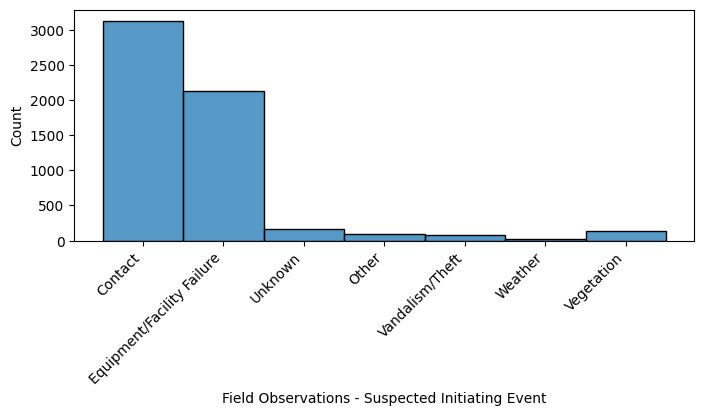

In [7]:
plt.figure(figsize=(8, 3))
plt.xticks(rotation=45, ha="right")

sns.histplot(x = df[ 'Field Observations - Suspected Initiating Event'])

<Axes: xlabel='Fire - Size (as int)', ylabel='Count'>

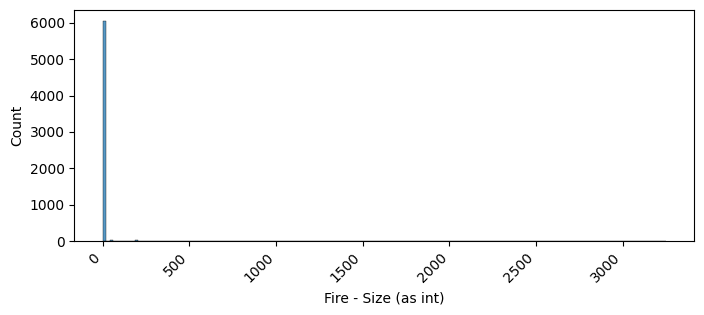

In [8]:
plt.figure(figsize=(8, 3))
plt.xticks(rotation=45, ha="right")

sns.histplot(x = df[ 'Fire - Size (as int)'])

Seeing these plots gives me an idea. It's pretty hard to see which incident types are actually worth looking into, because the size of fires resulting from these different causes, as far as I can tell so far, may be drastically different. However, we are mostly unable to plot them against each other, because of the heavily weighted distributions. I believe this calls for a histogram with stacked bars, but the stacks are so relatively short for some of these it would be practically useless. What we need is more of a tracking of distribution. We need to see what proportion of fires of each size are started by which kind of incident. I think I'll make the same stacked-color histogram, but with all the bars are equal height, so we can see the proportions as opposed to the sheer size.

*Update: I don't think this is something seaborn is capable of, I will need to go a bit more low-level with matplotlib*

*Update #2: I've made the stacked histogram-ey thing, but having each bar be the same size makes the visual representation an unnatural comparison to reality. After all, 50% of fires <.25 acres probably haven't done the same damage as 50% of the 100->500 acre fires, but it without careful thought, the graph makes it look that way. The solution I'm going to puruse is to make each bars width proportional to the total amount of burnt acreage by that size of fire, that way all the proportions can be compared horizontally as well as vertically.*

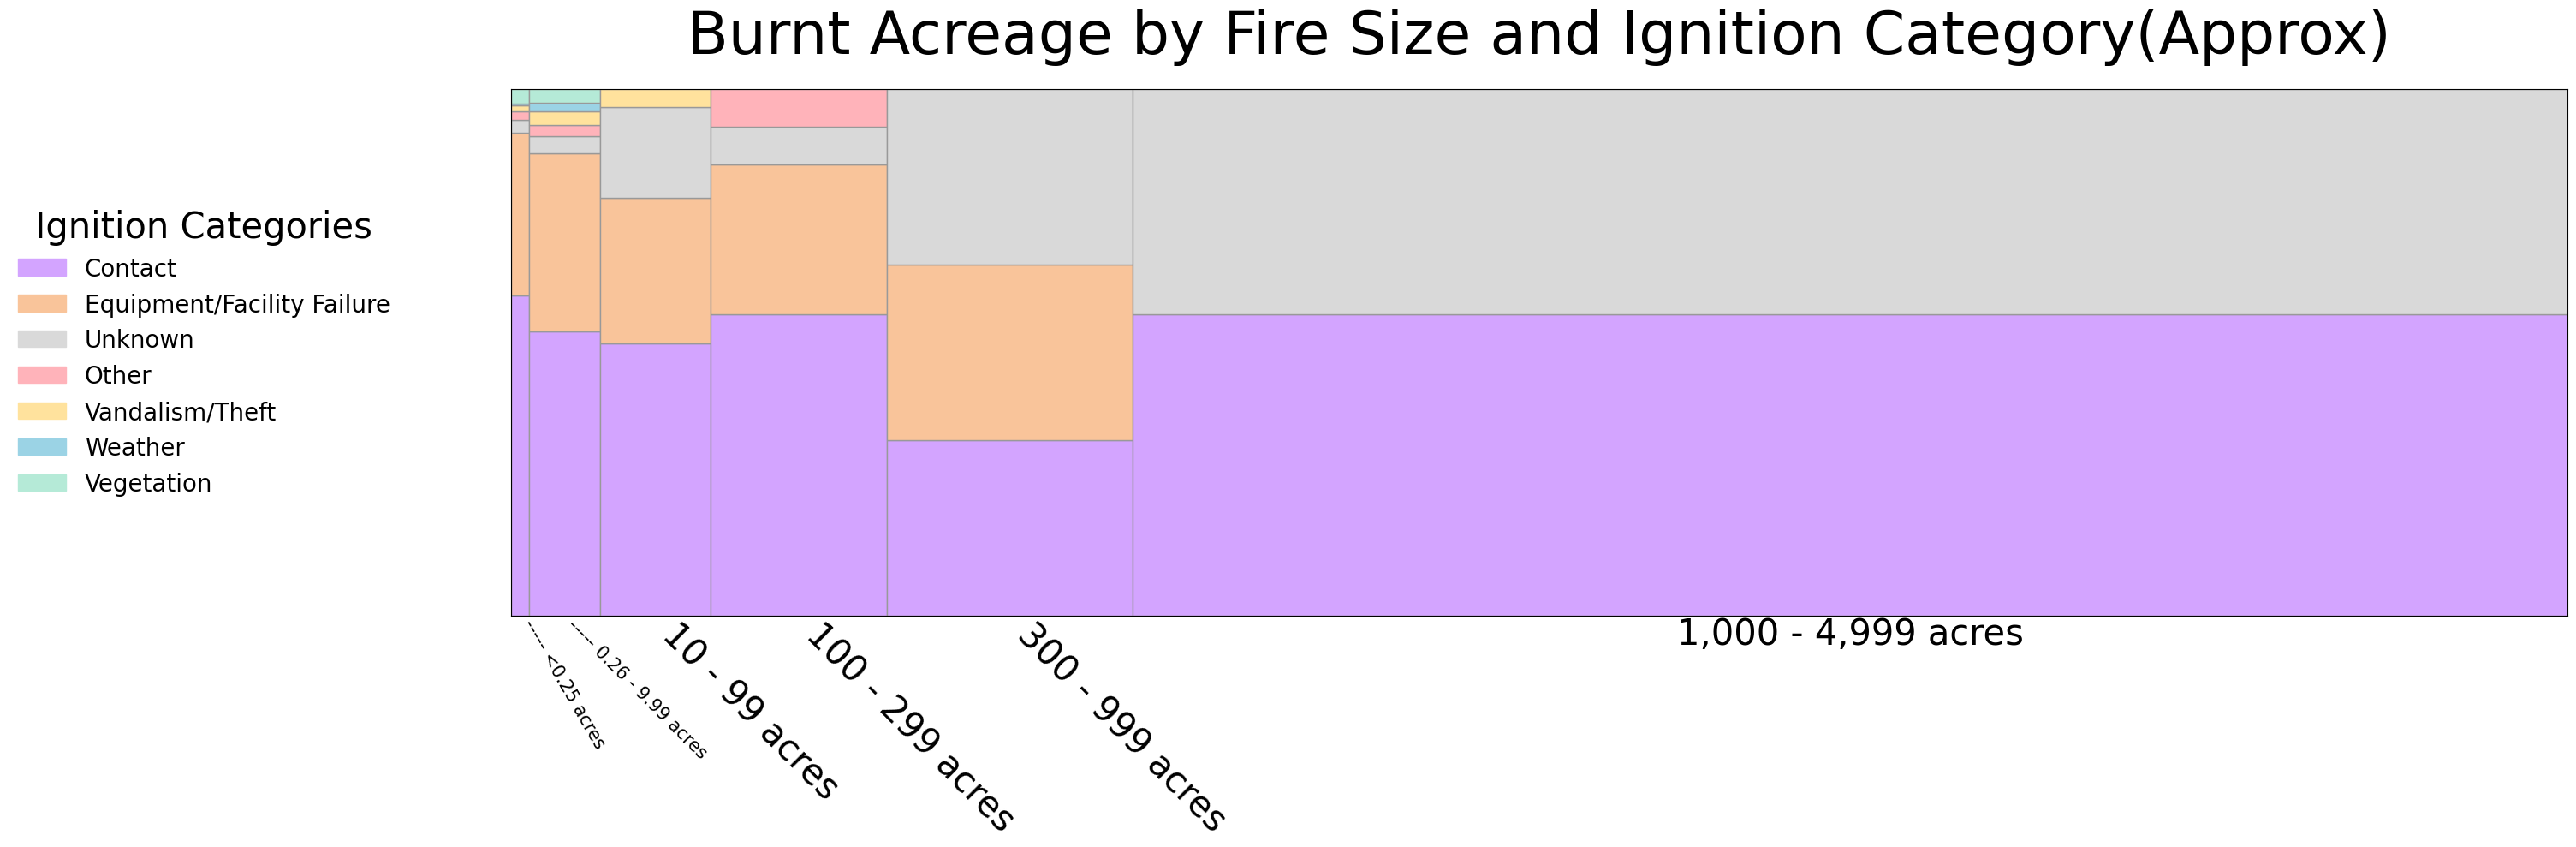

In [26]:
df = df.dropna(subset = ["Fire - Size (as int)"])

sm_df = df[[
    'Fire - Size (as int)',
    'Field Observations - Suspected Initiating Event',
]]

grouped = sm_df.groupby(['Fire - Size (as int)'])['Field Observations - Suspected Initiating Event'].value_counts()

total_counts = grouped.reset_index().groupby(['Fire - Size (as int)'])['count'].sum()

tc = total_counts.copy().reset_index()
tc['total_amt_burned'] = tc['Fire - Size (as int)']*tc['count']
proportion_of_burnt_area = tc['total_amt_burned']/(tc['total_amt_burned'].sum())

fire_sizes = df['Fire - Size (as int)'].unique()
observations = df['Field Observations - Suspected Initiating Event'].dropna().unique()

fire_sizes.sort()



# W to ChatGPT for coming up with these colors
colors = [
    '#D3A4FF',  # Contact - pastel purple
    '#F9C49A',  # Equipment/Facility Failure - pastel orange
    '#D9D9D9',  # Unknown- pastel gray
    '#FFB3BA',  # Vandalism/Theft - pastel pink
    '#FFE29D',  # Other - pastel yellow
    '#9BD3E5',  # Weather - pastel blue
    '#B5EAD7',  # Vegetation - soft green
]
edgecolor = '#999999'  # soft gray

fig_w = 30
fig_h = 10

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

if True:#Prettiness
    ax.set_title("Burnt Acreage by Fire Size and Ignition Category(Approx)", pad=30, fontsize = 50)  # moves title 30 points below the top of the axes

    # X-axis
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # Y-axis
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    import matplotlib.patches as mpatches
    
    
    # Create legend handles from colors
    handles = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, observations)]
    
    # Place legend to the left of y-axis
    ax.legend(
        handles=handles,
        title="Ignition Categories",
        loc='center left',       # vertically centered
        bbox_to_anchor=(-0.25, 0.5),  # move it left of the y-axis
        frameon=False,
        fontsize=20,
        title_fontsize=30
    )


hor_increments = fig_w/len(fire_sizes)
vert_mult = 1/fig_h

rots = [-90,-60,-45,-45,-45,-45,0]

cur_h_pos = 0
for fire_size_idx in range(len(fire_sizes))[1:]:
    cur_v_pos = 0
    for obs_idx in range(len(observations)):
        if True: #For marking purposes: Ensure the observation has existed for this record
            gpd = grouped.reset_index()
            
            if 0 == len(
                gpd.loc[
                    (gpd['Fire - Size (as int)'] == fire_sizes[fire_size_idx])
                    & (gpd['Field Observations - Suspected Initiating Event'] == observations[obs_idx])
            ]):
                continue

        bar_height = grouped[(fire_sizes[fire_size_idx],observations[obs_idx])]/total_counts[(fire_sizes[fire_size_idx])]
        bar_width = proportion_of_burnt_area[fire_size_idx]*hor_increments
        ax.bar(
            cur_h_pos,
            bar_height*vert_mult,
            bottom = cur_v_pos,
            width = bar_width,
            align = 'edge',
            
            color = colors[obs_idx],
            edgecolor = edgecolor
        )
        cur_v_pos += (bar_height*vert_mult)

    ax.text (
        cur_h_pos+(bar_width/2), 0,
        fire_size_strings[fire_size_idx] if fire_size_idx > 2 else fire_size_strings_elongated[fire_size_idx],
        
        ha="left" if rots[fire_size_idx] != 0 else "center",
        va="top",
        
        fontsize = 15 if fire_size_idx < 3 else 30,
        
        rotation = rots[fire_size_idx]
    )
        
        
    cur_h_pos += proportion_of_burnt_area[fire_size_idx]*hor_increments
plt.tight_layout()
ax.margins(0)
plt.show()

# Thoughts
I found this dataset interesting, and now that I'm looking at the final result, I have several interesting ideas for expand scope, and also improving this code. Here are a few.

### Improvements/Fixes

#### 1. Final Graph has Informational Issues
While I am quite proud of this graph, and I think it's got some good ideas, it also has two key flaws, which result in the reader **assuming that fire size is controllable in ways that it isn't, and that **.
The first is an inversion of the normal use of the axes. The X axis is traditionally (and as a result of natural patterns of eye movement) used to indicate the controllable dimension. But in this graph, it is not used in that manner, and the thing that those interested in the graph *ought* to look at are the areas of the boxes, and the dimension choice fights that. This might be partialy fixable by inverting X and Y, but even then, we have to make much more vague approximations to draw proper cause->effect conclusions. We have to compare boxes of with two different dimension, as opposed to boxes which share a dimension. I'm not entirely sure how to solve this, except to somehow algorithmically align similarly colored boxes (Or draw the whole thing to a grid, like a heatmap, in which case I believe you lose the sense of scale).

The second issue is that the change from number of fires to total acreage also can result in some misunderstanding on *how many records we have of fires in each bar (or sub-bar)*. While we might know after thinking that the >5000 acre fires don't need as many ocurrances as the <.25 acre fires to have a big an impact, that is not visually apparant, and making an assumption to the contrary can cause the reader to make disproportionately-weighted decisions. Ideally, if each category had a more visually comporable distribution, we would just add a second bar graph, either at the top or bottom, to show how many records each section has. Unfortunately, this is not possible, so I would probably have to settle for displaying the number of records on top of each column (maybe emphasized with color based on record count). A second, complementary graph

#### 2. Final Graph has poor code quality
The logic for the final graph is very messy. This *is* partially a result of time-commitment, but is also has a lot to do with how iteratively I approached the problem, and my unfamiliarity with some matplotlib specifics.

The majority of the time I've spent building graphs (in Python) was back when I first got interested in working with data at 14. Back then, I just wanted to get information on-screen so I could see what was going on, so I usually settled for using very high-level APIs like Seaborn. Working on this exercise, I didn't think at first I would need anything more complex than seaborn. However, when building my final plot, I kept iterating gradually wanting to express more and more information and nuance. This meant that my code structure, which worked very well for the simpler graphs I started with, slowly gained more and more complexity. If I were to re-do this, I would have planned for that extra state beforehand, and my now expanded knowledge of matplotlib would also help to that end.

While reading that code, I even found myself wondering if some improvements could be made in the way we interact with matplotlib. I love seaborn, and it's a very low-effort library, but I would assume there probably exists a middleground between having a high-level and low-expressiveness library like seaborn and a low-level and high-expressiveness library like matplotlib. It may be nothing (I did, after all, have the initial impression about state machines), but it's something I think I'll keep in the back of my head

### Expansions/Enhancements


#### 1. Develop a Natural-Language codegen tool for data cleaning
As a part of the data cleaning, I had to map a bunch of dirty strings to clean numbers. It was very annoying and tedious, and while doing it I couldn't help but feel like an LLM should be doing this work. Not for every record, but maybe you feed it a series of strings , and a list of categories, and it gives you a dict to map them with pd.Series.map(). The most fancy solution would be a local program with some storage and an LLM, which you hook into with a python API, but that sounds incredibly non-portable, so I may opt for some sort of custom prompt+storage engine for codegen in either my code editor or Jupyter or something similar. This might be over-optimizing the problem though, considering it would probably take under a minute to just do the printing and copy-pasting into a chat window. So maybe I'm just better off making the LLM more accessible in my setup.

#### 2. Incorporate Real Estate and Weather Data
I think there is some potential here to do some very interesting things with real estate and weather data, especially when you start thinking about wind direction. The simple idea would be to get the coordinates of all nearby real estate, and do a sort of weighted average to see how "expensive" a given fire was. Adding weather data to dhat, I would assume that fire moves in the direction of the wind, maybe broadening as it goes. You could incorporate that sort of knowledge with a sort of "average fire travel" pattern, drawn on a circle. With this, and the relevant distribution of wind direction, we could do some trig with polar coords and some statistics (maybe calc would be needed if you used patterns which are complex enough), you could probably come up with a much more accurate model of cost for damages based on fire location than a simple distance.

I don't know how helpful it would be (maybe the knowledge-usage is too long-term), but it would be interesting to have an interactive interface to see how changes in patterns of fire travel and wind direction effect risks in different areas, updated live.